In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

In [112]:
# ============================
# 1. Data Loading
# ============================

annee = 2022
def chargement_et_preparation_donnees_annee(annee):
    df = pd.read_csv(r'C:\Users\selim\Desktop\Data_total\Data_TESLA_2022_2025.csv')
    df = df.drop_duplicates(subset="id")
    df['query_date'] = pd.to_datetime(df['query_date'])
    df['year'] = df['query_date'].dt.year
    df['month'] = df['query_date'].dt.month
    df = df.sort_values(by='query_date').reset_index(drop=True)
    df = df[df['year'] == annee]
    return df

df_annee_2022 = chargement_et_preparation_donnees_annee(annee)


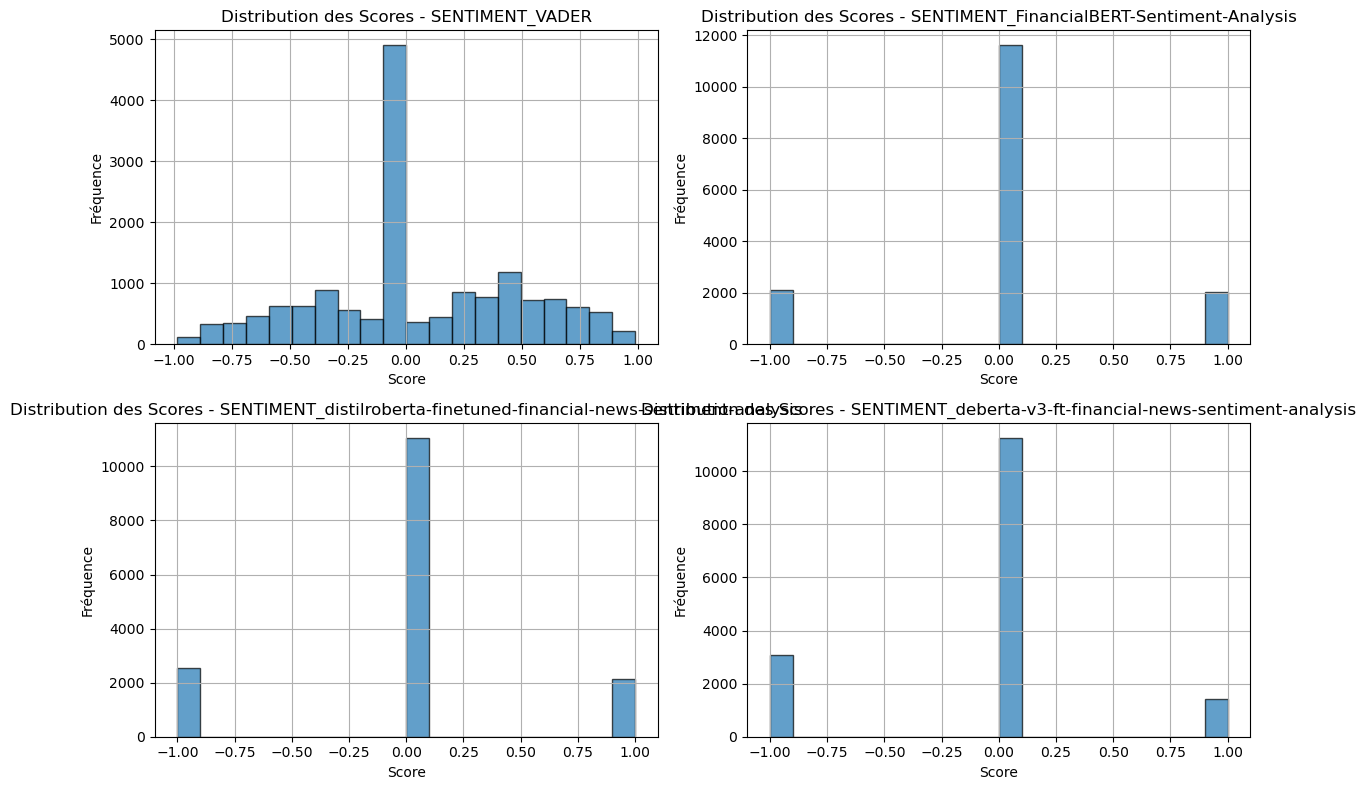

In [113]:
# ============================
# 2. Displaying Sentiment Distributions
# ============================

sentiment_cols = [
    'SENTIMENT_VADER',
    'SENTIMENT_FinancialBERT-Sentiment-Analysis',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis'
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, model in enumerate(sentiment_cols):
    axes[i].hist(df_annee_2022[model], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(f"Distribution des Scores - {model}")
    axes[i].set_xlabel("Score")
    axes[i].set_ylabel("Fréquence")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


We observe that most models classify the vast majority of tweets as neutral (0), with only a few extreme values at –1 (negative) or +1 (positive).

This distribution can be explained in two ways:

- The tweets are genuinely neutral, lacking strong expressions of positive or negative opinion.
- The models apply a biased interpretation and default to neutral scores, failing to capture nuanced language.

For the remainder of the project, we will assume the tweets are indeed neutral.  
After rereading several tweets, we see that many of them truly are neutral, with no expression of opinion or judgment. Such tweets carry no emotional charge or clear intent, are assumed to have no influence on the market, and will therefore be excluded from the project’s strategic analyses.


In [114]:
# ============================
# 3. Daily Aggregation by Verification Status, Filtered to 2022
# ============================
for sentiment_col in sentiment_cols:
    df_annee_2022 = df_annee_2022[df_annee_2022[sentiment_col].abs()>0.1]

df_verified = df_annee_2022[df_annee_2022['verified']]
df_non_verified = df_annee_2022[~df_annee_2022['verified']]

def daily_sentiment_avg_weighted(df, sentiment_cols, weight_verified=0.5, weight_non_verified=0.5):
    
    df_verified = df[df['verified']]
    df_non_verified = df[~df['verified']]

    # Mean per group
    daily_verified = df_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()
    daily_non_verified = df_non_verified.groupby(['query_date', 'year', 'month'])[sentiment_cols].mean()

    # Dataframes mearging
    df_combined = pd.merge(daily_verified, daily_non_verified, 
                           left_index=True, right_index=True, 
                           suffixes=('_verified', '_non_verified'))

    # Calculation of the weighted average
    weighted_sentiments = {}
    for col in sentiment_cols:
        verified_col = f"{col}_verified"
        non_verified_col = f"{col}_non_verified"
        weighted_sentiments[col] = (
            weight_verified * df_combined[verified_col] +
            weight_non_verified * df_combined[non_verified_col]
        )

    # Building the Dataframe
    df_weighted = pd.DataFrame(weighted_sentiments)
    df_weighted.reset_index(inplace=True)
    df_weighted.rename(columns={'query_date': 'date'}, inplace=True)
    df_weighted['date'] = pd.to_datetime(df_weighted['date'])

    return df_weighted

df_daily = daily_sentiment_avg_weighted(df_annee_2022, sentiment_cols, weight_verified=0.25, weight_non_verified=0.75)
df_daily['date'] = pd.to_datetime(df_daily['date']).dt.normalize()
df_daily


,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis
0,2022-01-02,2022,1,0.292875,-1.000000,-1.000000,0.500000
1,2022-01-03,2022,1,0.538913,1.000000,1.000000,1.000000
2,2022-01-04,2022,1,-0.086175,0.200000,0.400000,0.400000
3,2022-01-05,2022,1,0.367800,1.000000,1.000000,1.000000
4,2022-01-06,2022,1,-0.169650,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
232,2022-12-26,2022,12,0.273500,-0.500000,-0.500000,-0.500000
233,2022-12-27,2022,12,-0.418033,-0.625000,-0.625000,-0.625000
234,2022-12-28,2022,12,-0.146321,-0.208333,-0.041667,-0.208333
235,2022-12-29,2022,12,0.286355,0.625000,0.625000,0.625000


In [115]:
# ============================
# 4. Market data (META)
# ============================

# Data loading
df_market = pd.read_csv(r'C:\Users\selim\Desktop\Data_total\TSLA_market.csv')

if isinstance(df_market.columns, pd.MultiIndex):
    df_market.columns = df_market.columns.get_level_values(0)
if 'date' not in df_market.columns:
    df_market['date'] = pd.to_datetime(df_market['date'], errors='coerce')
else:
    df_market['date'] = pd.to_datetime(df_market['date'], errors='coerce')

df_market = df_market[df_market['date'].notna()]
df_market = df_market[["date", "Open", "High", "Low", "Close", "Volume", "Variation %"]]
df_market['date'] = df_market['date'].dt.floor('D')
df_market = df_market.sort_values("date").reset_index(drop=True)

df_market.head()


,date,Open,High,Low,Close,Volume,Variation %
0,2022-01-03,382.58,400.36,378.68,399.93,104690000.0,"13,53%"
1,2022-01-04,396.52,402.67,374.35,383.20,100250000.0,"-4,18%"
2,2022-01-05,382.22,390.11,360.34,362.71,80120000.0,"-5,35%"
3,2022-01-06,359.00,362.67,340.17,354.90,90340000.0,"-2,15%"
4,2022-01-07,360.12,360.31,336.67,342.32,84160000.0,"-3,54%"


In [116]:
# ============================
# 5. Data Merging
# ============================

df_combined = pd.merge(df_daily, df_market, on="date", how="inner")

# 7 days rolling mean
rolling_cols = df_combined.select_dtypes(include='number').columns

rolling_cols = rolling_cols[~rolling_cols.isin(['year', 'month', 'date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Change_%'])]
df_rolling_verified_combined = df_combined.copy()
df_rolling_verified_combined[rolling_cols] = df_combined[rolling_cols].rolling(window=1).mean()
df_rolling_verified_combined.head()

,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis,Open,High,Low,Close,Volume,Variation %
0,2022-01-03,2022,1,0.538913,1.00,1.00,1.00,382.58,400.36,378.68,399.93,104690000.0,"13,53%"
1,2022-01-04,2022,1,-0.086175,0.20,0.40,0.40,396.52,402.67,374.35,383.20,100250000.0,"-4,18%"
2,2022-01-05,2022,1,0.367800,1.00,1.00,1.00,382.22,390.11,360.34,362.71,80120000.0,"-5,35%"
3,2022-01-06,2022,1,-0.169650,0.00,0.00,0.00,359.00,362.67,340.17,354.90,90340000.0,"-2,15%"
4,2022-01-07,2022,1,0.098525,0.25,0.25,0.25,360.12,360.31,336.67,342.32,84160000.0,"-3,54%"


In [117]:

# ============================
# 6. Normalisation
# ============================

# Normalization of daily variation
mean_close = df_rolling_verified_combined["Close"].mean()
std_close = df_rolling_verified_combined["Close"].std()
df_rolling_verified_combined["Close_normalized"] = (df_rolling_verified_combined["Close"]-mean_close) / std_close
max_abs_open = df_rolling_verified_combined["Open"].abs().max()
df_rolling_verified_combined["Open_normalized"] = df_rolling_verified_combined["Open"] / max_abs_open

# Normalization of sentiment scores
for col in sentiment_cols:
    max_abs_sent = df_rolling_verified_combined[col].abs().max()
    df_rolling_verified_combined[col + "_normalized"] = (df_rolling_verified_combined[col])/max_abs_sent

df_rolling_verified_combined.head()

,date,year,month,SENTIMENT_VADER,SENTIMENT_FinancialBERT-Sentiment-Analysis,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis,Open,High,Low,Close,Volume,Variation %,Close_normalized,Open_normalized,SENTIMENT_VADER_normalized,SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized,SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized,SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_normalized
0,2022-01-03,2022,1,0.538913,1.00,1.00,1.00,382.58,400.36,378.68,399.93,104690000.0,"13,53%",2.188344,0.964844,0.667922,1.00,1.00,1.00
1,2022-01-04,2022,1,-0.086175,0.20,0.40,0.40,396.52,402.67,374.35,383.20,100250000.0,"-4,18%",1.923257,1.000000,-0.106804,0.20,0.40,0.40
2,2022-01-05,2022,1,0.367800,1.00,1.00,1.00,382.22,390.11,360.34,362.71,80120000.0,"-5,35%",1.598593,0.963936,0.455847,1.00,1.00,1.00
3,2022-01-06,2022,1,-0.169650,0.00,0.00,0.00,359.00,362.67,340.17,354.90,90340000.0,"-2,15%",1.474843,0.905377,-0.210262,0.00,0.00,0.00
4,2022-01-07,2022,1,0.098525,0.25,0.25,0.25,360.12,360.31,336.67,342.32,84160000.0,"-3,54%",1.275513,0.908201,0.122111,0.25,0.25,0.25


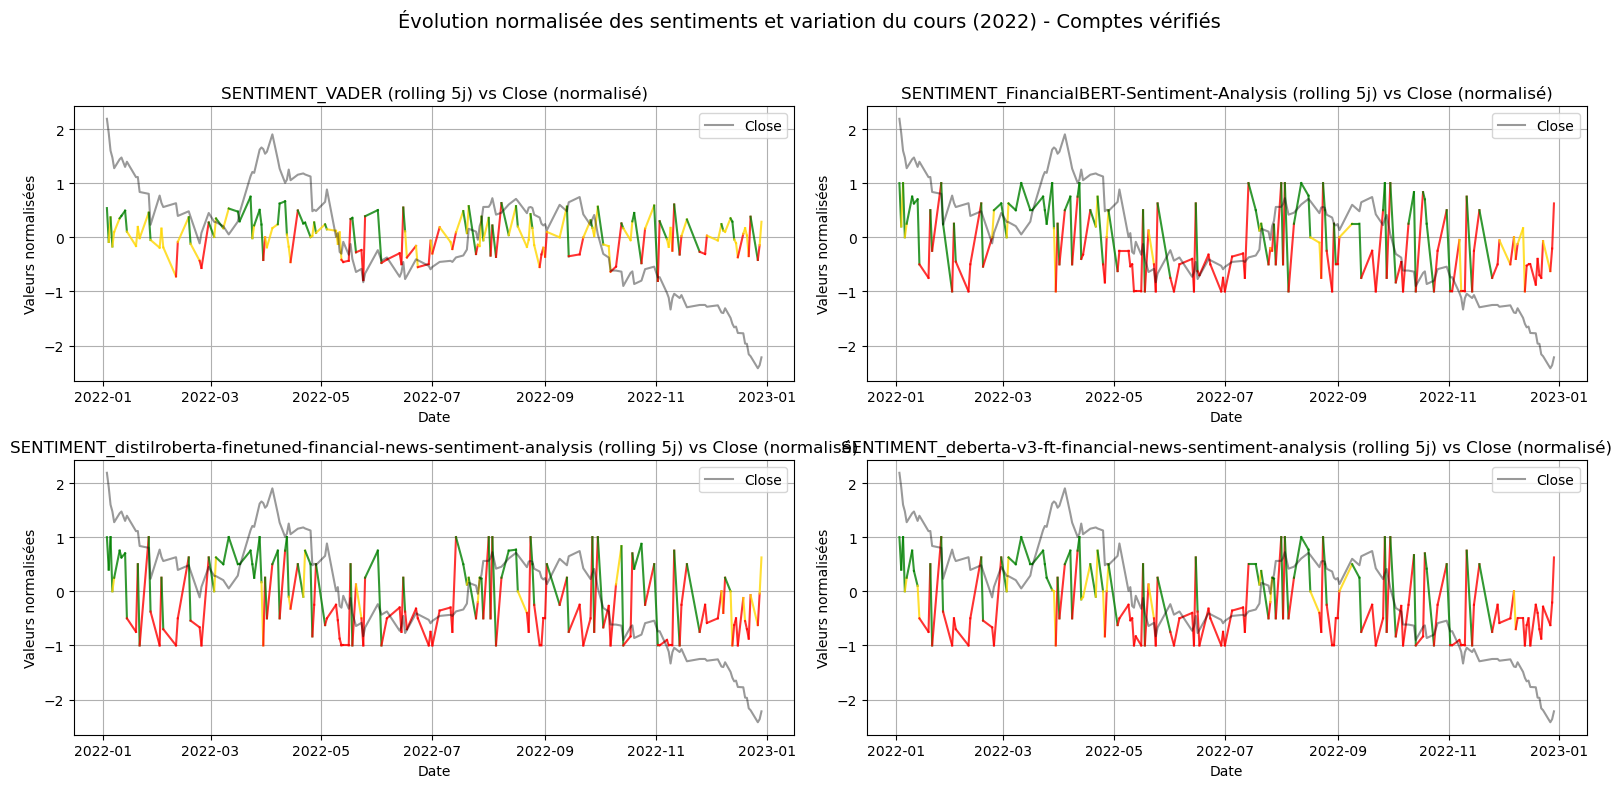

In [118]:
# ============================
# 7. Conditional-Color Visualization
# ============================

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(sentiment_cols):
    sentiment_norm = col + "_normalized"

    x = df_rolling_verified_combined['date']
    y = df_rolling_verified_combined[col]

    prev_x, prev_y = x.iloc[0], y.iloc[0]
    
    # Plot the curve with color change based on the value
    for j in range(1, len(x)):
        curr_x, curr_y = x.iloc[j], y.iloc[j]

        # Determine the color based on the previous value
        if prev_y > 0.2:
            color = 'green'
        elif prev_y < -0.2:
            color = 'red'
        else:
            color = 'gold'

        axes[i].plot([prev_x, curr_x], [prev_y, curr_y], color=color, alpha=0.8)

        prev_x, prev_y = curr_x, curr_y

    # Add the price curve
    axes[i].plot(df_rolling_verified_combined['date'], df_rolling_verified_combined['Close_normalized'], label='Close', color='black', alpha=0.4)

    axes[i].set_title(f"{col} (rolling 5j) vs Close (normalisé)")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Valeurs normalisées")
    axes[i].legend()
    axes[i].grid(True)

plt.suptitle("Évolution normalisée des sentiments et variation du cours (2022) - Comptes vérifiés", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [119]:
# ============================
# 7. Buy/Sell Strategy
# ============================

# Fonction de simulation de stratégie d'achat/vente
def simulate_trading(df, sentiment_col, rolling_window=5, weight_verified=0.5, initial_cash=10000, buy_threshold=0.2, sell_threshold=-0.2):
    """
    Simule une stratégie simple d'achat/vente basée sur le score de sentiment pondéré.

    """
    df = df.copy()

    # Lissage du sentiment
    df['sentiment_smooth'] = df[sentiment_col].rolling(window=rolling_window, min_periods=1).mean()

    position = 0 
    cash = initial_cash 

    for idx, row in df.iterrows():
        sentiment = row['sentiment_smooth']
        price = row['Open']  # Achat/vente à l'ouverture du jour

        # Signal d'achat
        if sentiment > buy_threshold and position == 0:
            position = cash / price
            cash = 0

        # Signal de vente
        elif sentiment < sell_threshold and position > 0:
            cash = position * price
            position = 0

    # Valeur finale du portefeuille
    final_value = cash + position * df.iloc[-1]['Close']
    percent_return = (final_value - initial_cash) / initial_cash * 100

    return percent_return


result = simulate_trading(
    df=df_rolling_verified_combined,
    sentiment_col='SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized',
    rolling_window=2,
    weight_verified=0.25,
    initial_cash=10000
)
print(f"Résultat de la simulation : {result:.2f}%")


Résultat de la simulation : 1.71%


### Interpretation of the Initial Result

This result shows that the strategy manages to capture a **small exploitable signal from Twitter sentiment**.

It is not huge (I finish at **$10,171**), but it is **positive**, which is encouraging given that:

- I used an **extremely simple model**,
- the **parameters have not been optimized**,
- and **the stock price declined overall this year**, making it even harder to detect upswings.

---
### Next Step

We will now **optimize the parameters** for this year to see:

- the **best possible return** achievable with this strategy,
- and **which parameters** (model, thresholds, smoothing) make it happen.


In [120]:
# ============================
# 8. Parameter Optimization
# ============================


best_result = -np.inf
best_params = {}

for sentiment_col in [
    'SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized',
    'SENTIMENT_distilroberta-finetuned-financial-news-sentiment-analysis_normalized',
    'SENTIMENT_deberta-v3-ft-financial-news-sentiment-analysis_normalized',
    'SENTIMENT_VADER_normalized'
]:
    for rolling in range(1, 8):
        for buy_t in np.arange(0, 1, 0.1):
            for sell_t in np.arange(-1, 0, 0.1):
                result = simulate_trading(
                    df=df_rolling_verified_combined,
                    sentiment_col=sentiment_col,
                    rolling_window=rolling,
                    buy_threshold=buy_t,
                    sell_threshold=sell_t,
                    initial_cash=10000
                )
                if result > best_result:
                    best_result = result
                    best_params = {
                        'model': sentiment_col,
                        'rolling': rolling,
                        'buy_threshold': buy_t,
                        'sell_threshold': sell_t,
                        'return': result
                    }

print("🏆 Meilleure configuration trouvée :")
print(best_params)


🏆 Meilleure configuration trouvée :
{'model': 'SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized', 'rolling': 1, 'buy_threshold': 0.30000000000000004, 'sell_threshold': -0.5000000000000001, 'return': 75.8631664704837}


### Optimization Result

Automatic optimization tested **multiple sentiment models**, **different smoothing windows**, and **various buy/sell thresholds**.

The **best configuration found** is:

- **Model**: `SENTIMENT_FinancialBERT-Sentiment-Analysis_normalized`
- **Smoothing window** (`rolling`): `1` (no smoothing)
- **Buy threshold** (`buy_threshold`): `0.3`
- **Sell threshold** (`sell_threshold`): `-0.5`
- **Return achieved**: **+75.86 %**

---
### Interpretation

This setup delivers an **impressive return of +75.86 %**, purely by relying on **Twitter sentiment** with a finance-specialized NLP model.

This suggests that:

- The **FinancialBERT** model is particularly effective for this year.
- A strategy with **instant reaction** (rolling = 1) works better here than smoothing.
- The buy threshold of `0.3` (absolute value) is **lower than the sell threshold of `-0.5`**, meaning the strategy **triggers buys more easily** than sells.
- In other words, **moderate optimism** is enough to buy, whereas **stronger pessimism** is needed to sell according to FinancialBERT.
- Even though 2023 was a bearish market, there were **exploitable opportunities detected via sentiment signals**.

---
### Conclusion

This simulation shows that a **well-calibrated sentiment model** can provide meaningful signals for an investment strategy, even without classic technical indicators.  
It is an encouraging proof of concept for integrating **social data** into stock-market decision-making.